# Examples of loging non Snowpark ML models into the Snowpark Model Registry

In [3]:
# Import needed Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
from snowflake.ml.registry import Registry

# Common modules for all examples
import pandas as pd
import numpy as np

### Connect to Snowflake

This example is using the connections.toml file to connect to Snowflake. You can read more at https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-connect#connecting-using-the-connections-toml-file how to set it up.

In [4]:
CONNECTION_NAME = 'mstellwall_aws_us_west3' # Name of the connection in connections.toml to be used to connect to Snowflake
DATABASE_NAME = 'SNOWPARK_DEMO_DB' # Database to use for data
DATABASE_SCHEMA = 'SOURCE_DATA' # Name of schema to store data in and where wource data is
FULLY_QUALIFIED_NAME = f"{DATABASE_NAME}.{DATABASE_SCHEMA}"

snf_session = Session.builder.config("connection_name", CONNECTION_NAME).create()
snf_session.use_schema(FULLY_QUALIFIED_NAME)
snf_session.get_fully_qualified_current_schema()

'"SNOWPARK_DEMO_DB"."SOURCE_DATA"'

In [5]:
# 
snowml_registry = Registry(snf_session)

## OOTB Models
### Scikit-Learn

Train a RandomForestRegressor model within a pipline and log the fitted pipeline into the Snowpark Model Registry

In [ ]:
# SKLearn Imports
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



Get some data to use for training

In [ ]:

# Use the diamond dataset
data = pd.read_csv("https://raw.githubusercontent.com/tidyverse/ggplot2/882584f915b23cda5091fb69e88f19e8200811bf/data-raw/diamonds.csv", sep=',')

# rename table to table_pct so we do not have any issues with selecting teh column when using data in snowflake
data.rename(columns={'table': 'table_pct'}, inplace=True)

data.head()


Define categorical and numerical columns, create X and y datastest and split them into train and test

In [ ]:
CATEGORICAL_COLUMNS = ["cut", "color", "clarity"]
NUMERICAL_COLUMNS = ["carat", "depth", "table_pct", "x", "y", "z"]
X = data.drop(["price"], axis=1)
y = data.price

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=123)

Create a Pipeline that do preprocessing and then fit a RandomForestRegressor

In [ ]:

categories = [
    np.array(["Ideal", "Premium", "Very Good", "Good", "Fair"]), # cut
    np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']), # color
    np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]), # clarity
]

cat_transformer = Pipeline(steps=[
        ('oe', OrdinalEncoder(categories=categories))
    ])

num_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler(clip=True))
    ])

# Combine into a column transformer
preprocessor = ColumnTransformer(
    [
        ('num', num_transformer, NUMERICAL_COLUMNS),
        ('cat', cat_transformer, CATEGORICAL_COLUMNS),
    ],  verbose_feature_names_out=False,
)


# Create a pipeline with the column transformer and training of a Random Forrest Classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestRegressor(n_jobs=-1))])

# Train
pipeline.fit(X_train, y_train)

Calculate the MAPE on the test data

In [ ]:
# Eval
y_pred = pipeline.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean absolute percentage error: {mape}")

Every model saved in the Snowpark Model Registry needs a unique name within the schema it is saved in, a model name can have multiple versions where each version needs a unique name (within the model).

In [ ]:
skl_model_name = "skl_diamonds"
skl_version_name = 'V1'


Log the SKLearn pipeline

In [ ]:
skl_mv = snowml_registry.log_model(model=pipeline, 
                                   model_name = skl_model_name, 
                                   version_name = skl_version_name,
                                   sample_input_data = X_train.head(),
                                   metrics = {"test_mape": mape},
                                   comment='SKLearn pipline'
                                )


We can check what functions we have avalible by using **show_functions()**

In [ ]:
skl_mv.show_functions()

Create a Snowpark DataFrame to test the deployed model

In [ ]:
snf_test_df = snf_session.create_dataframe([[0.23, 'Ideal', 'E', 'SI2', 61.5, 55.0, 3.95, 3.98, 2.43]]
                                           , schema=['carat', 'cut', 'color', 'clarity', 'depth', 'table_pct', 'x', 'y', 'z'])
snf_test_df.show()

USe the model on the Snowpark DataFrame

In [ ]:
skl_mv.run(snf_test_df).show()

### XGBoost

In [1]:
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

In [6]:
bst_mv = snowml_registry.log_model(model=bst # This is the fitted XGBoost object
                                    , model_name= "my_xgboost_model" 
                                    , version_name= "V1"
                                    , sample_input_data=X_train # In order to get the correct signature for the model, sample data (without target) needs to be applied
                                    , conda_dependencies = ['xgboost==1.7.3']
                            )

/Users/mstellwall/anaconda3/envs/snowml_latest_311/lib/python3.11/contextlib.py:137: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)
/Users/mstellwall/anaconda3/envs/snowml_latest_311/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:69: UserWarning: The sample input has 120 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(


# Using CustomModel

https://docs.snowflake.com/en/developer-guide/snowpark-ml/reference/latest/model#snowflake-ml-model-custom-model

In [25]:
# Needed additional Snowpark ML modules
from snowflake.ml.model import custom_model
from snowflake.ml.model import model_signature

import os
import shutil

## PyCaret

In [ ]:
# Needed PyCaret modules
from pycaret.classification import ClassificationExperiment, predict_model, load_model
from pycaret.datasets import get_data

Start by running a Classification Experiment using the Juice dataset

In [ ]:
data = get_data('juice')

cl_exp = ClassificationExperiment()
cl_exp.setup(data, target='Purchase', session_id=123)
best_model = cl_exp.compare_models()

In order to log the model/experiment into the Snowpark Model Registry we need to 
1) Serilize the model into a file
2) Create a CustomModel class

Start by saving the model as afile using the *save_model* method

In [ ]:
# Save model as file
cl_exp.save_model(best_model, "juice_best_model")

We need to set up a file structure to be used for the CustomModel and to move the saved file into it.

In [ ]:

ARTIFACTS_DIR = "/tmp/pycaret/"
# Create the directory where we will move the file
os.makedirs(os.path.join(ARTIFACTS_DIR, "model"), exist_ok=True)
# Move the saved model into the directory
shutil.move('juice_best_model.pkl', os.path.join(ARTIFACTS_DIR, 'model',  'juice_best_model.pkl'))

Next step is to create a CustomModel class that will be used in Snowflake when calling the methods/functions of the model. In this case we will only support the *predict* function, but if wanted to support addtional functions we would specifiy those as methonds of our class

In [ ]:
# Name of the class
class PyCaretModel(custom_model.CustomModel):
    # The init function is used to load the model file
    def __init__(self, context: custom_model.ModelContext) -> None:
        super().__init__(context)
        # The model is saved with .pkl prefix, and the filename will be part of the properties of the ModelContext
        # we craete when logging it to Snowflake. Since PyCaret load function does not support using the prefix we 
        # need to remove it from the name
        model_dir = self.context.path("model_file")[:-4]
        # Load the model
        self.model = load_model(model_dir, verbose=False)
        # When running this model in Snowflake it will use a WH and we do not have access to /var/ on the nodes so
        # we need to change to a directory we have access to in this case /tmp/
        self.model.memory='/tmp/' 

    @custom_model.inference_api
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        model_output = predict_model(self.model, data=X)
        res_df = pd.DataFrame({"prediction_label": model_output['prediction_label'], "prediction_score": model_output['prediction_score']})
        
        return res_df

We can now use this CustomModel class every time we want to log a PyCaret ClassificationExperiment to Snowflake.

Before logging the model we need to define the ModelContext, that will point to the artifatcs, file, needed when using the model in Snowflake.

In [ ]:
pycaret_mc = custom_model.ModelContext(
	models={ # This should be for models that is supported by Model Registry
	},
	artifacts={ # Everything not supported needs to be here
		'model_file': os.path.join(ARTIFACTS_DIR, "model",  'juice_best_model.pkl'),
	}
)


We can now create a new Model object and test that with some data, we will save the predictions into a Pandas DataFrame so we can use it later when generating a model signature

In [ ]:
my_pycaret_model = PyCaretModel(pycaret_mc)

new_data = data.copy().drop('Purchase', axis=1)

output_pd = my_pycaret_model.predict(new_data)
output_pd

Every model saved in the Snowpark Model Registry needs a unique name within the schema it is saved in, a model name can have multiple versions where each version needs a unique name (within the model).

In [ ]:
model_name = "pycaret_juice"
version_name = "v1"

Before logging teh model we need to provide a Model Signauture. A Model Signature can be created using sample data for the input and output and we can use the *model_signature.infer_signature* function to generate it from the 
data.

In thsi case we can use the **new_data** Pandas DataFrame as the input_data and **output_pd** Pandas DataFrame as the output.

In [ ]:
# Need to create signature since 
predict_sign = model_signature.infer_signature(input_data=new_data.sample(100), output_data=output_pd.sample(100))
predict_sign

We can now log the model,  we will use the moel signature for the predict function

In [ ]:
custom_mv = snowml_registry.log_model(
    my_pycaret_model,
    model_name=model_name,
    version_name=version_name,
    conda_dependencies=["pycaret"],
    signatures={"predict": predict_sign},
    comment = 'PyCaret ClassificationExperiment using the CustomModel API'
)

In [ ]:
new_data_snowflake = snf_session.write_pandas(new_data,"pycaret_input_data", auto_create_table=True, overwrite=True, quote_identifiers=False )
new_data_snowflake.show()

In [ ]:
custom_mv.run(new_data_snowflake, function_name='predict').show()

```
SELECT 
 pycaret_juice!predict(*) as predict_dict,
 predict_dict['prediction_label']::text as prediction_label,
 predict_dict['prediction_score']::double as prediction_score
from pycaret_input_data;
```

## Lifetimes

In [4]:
df_order = snf_session.table("SNOWFLAKE_SAMPLE_DATA.TPCH_SF1.ORDERS").drop(['O_ORDERPRIORITY', 'O_CLERK', 'O_SHIPPRIORITY', 'O_COMMENT'])
df_order.show()

---------------------------------------------------------------------------------
|"O_ORDERKEY"  |"O_CUSTKEY"  |"O_ORDERSTATUS"  |"O_TOTALPRICE"  |"O_ORDERDATE"  |
---------------------------------------------------------------------------------
|3000001       |145618       |F                |30175.88        |1992-12-17     |
|3000002       |1481         |O                |297999.63       |1995-07-28     |
|3000003       |127432       |O                |345438.38       |1997-11-04     |
|3000004       |47423        |O                |135965.53       |1996-06-13     |
|3000005       |84973        |F                |209937.09       |1992-09-12     |
|3000006       |135136       |O                |140186.32       |1996-09-26     |
|3000007       |78841        |F                |298655.07       |1992-04-13     |
|3000032       |124576       |F                |175973.90       |1992-03-02     |
|3000033       |30247        |F                |4635.38         |1993-11-10     |
|3000034       |

In [5]:
df_order_rfm = df_order.group_by("O_CUSTKEY").agg(F.count(F.col("O_ORDERKEY")).alias("FREQUENCY")
                                                  , F.max(F.col("O_ORDERDATE")).alias("MAX_ORDER_DATE")
                                                  , F.min(F.col("O_ORDERDATE")).alias("MIN_ORDER_DATE")
                                                  , F.sum(F.col("O_TOTALPRICE")).alias("MONETARY"))
df_order_rfm.show()

--------------------------------------------------------------------------------
|"O_CUSTKEY"  |"FREQUENCY"  |"MAX_ORDER_DATE"  |"MIN_ORDER_DATE"  |"MONETARY"  |
--------------------------------------------------------------------------------
|29846        |14           |1997-08-20        |1992-02-08        |1330688.93  |
|23305        |18           |1998-04-29        |1992-07-27        |3175788.83  |
|17122        |22           |1998-03-31        |1992-05-23        |3300650.14  |
|123745       |21           |1998-07-12        |1992-05-10        |3643726.71  |
|131644       |21           |1998-01-08        |1992-01-01        |2605833.23  |
|73264        |24           |1998-07-01        |1992-01-12        |3890113.43  |
|3866         |8            |1998-02-20        |1992-04-10        |1121578.59  |
|116611       |29           |1997-12-30        |1992-08-04        |3315850.32  |
|21163        |20           |1998-04-13        |1992-03-28        |2987725.36  |
|120694       |21           

In [6]:
from datetime import timedelta 
start_date = df_order.select(F.max("O_ORDERDATE")).collect()[0][0] + timedelta(days=1)
start_date

datetime.date(1998, 8, 3)

In [7]:
#spd_order_rfm['RECENCY'] = spd_order_rfm['MAX_ORDER_DATE'].apply(lambda x: (start_date - x).days)
df_order_rfm = df_order_rfm.with_columns(["RECENCY", "T"]
                                         , [F.daydiff(F.lit(start_date), F.col("MAX_ORDER_DATE"))
                                            ,F.daydiff(F.lit(start_date), F.col("MIN_ORDER_DATE")) ]).drop(["MAX_ORDER_DATE", "MIN_ORDER_DATE"])
df_order_rfm.show()

-------------------------------------------------------------
|"O_CUSTKEY"  |"FREQUENCY"  |"MONETARY"  |"RECENCY"  |"T"   |
-------------------------------------------------------------
|72209        |8            |1241132.91  |20         |2054  |
|116965       |23           |3449015.64  |134        |2325  |
|101956       |18           |2742732.61  |3          |2138  |
|98882        |15           |2007794.38  |97         |2200  |
|3664         |21           |3175223.15  |36         |2276  |
|22730        |9            |1276378.37  |121        |2276  |
|89569        |21           |3315702.05  |176        |2372  |
|59032        |25           |3656786.74  |54         |2112  |
|55615        |26           |3792303.49  |122        |2292  |
|48752        |11           |861732.32   |279        |2187  |
-------------------------------------------------------------



In [17]:
pd_order_rfm = df_order_rfm.to_pandas()

In [19]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.2)
bgf.fit(pd_order_rfm['FREQUENCY'], pd_order_rfm['RECENCY'], pd_order_rfm['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 99996 subjects, a: 0.33, alpha: 1.08, b: 0.93, r: 0.47>


In [20]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.469788,0.001712,0.466432,0.473144
alpha,1.077830,0.007073,1.063966,1.091693
a,0.330412,0.001177,0.328104,0.332719
b,0.933580,0.003361,0.926993,0.940167


In [21]:
t = 1
pd_order_rfm['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, pd_order_rfm['FREQUENCY'], pd_order_rfm['RECENCY'], pd_order_rfm['T'])
pd_order_rfm.sort_values(by='predicted_purchases').tail(5)

,O_CUSTKEY,FREQUENCY,MONETARY,RECENCY,T,predicted_purchases
12282,59816,3,497119.69,244,386,0.005781
8801,110939,4,728535.56,213,372,0.005970
96602,37700,3,509329.10,163,294,0.006308
37448,32471,2,447676.30,94,118,0.015957
86321,42239,1,65877.82,55,55,0.019297


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

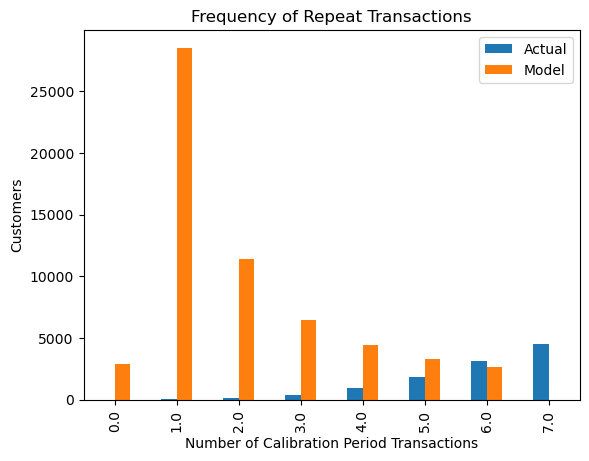

In [22]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [ ]:
bgf.save_model('bgf.pkl')

In [26]:
ARTIFACTS_DIR = "/tmp/lifetimes/"
# Create the directory where we will move the file
os.makedirs(os.path.join(ARTIFACTS_DIR, "model"), exist_ok=True)
# Move the saved model into the directory
shutil.move('bgf.pkl', os.path.join(ARTIFACTS_DIR, 'model',  'bgf.pkl'))



'/tmp/lifetimes/model/bgf.pkl'

In [27]:
#bgf_loaded = BetaGeoFitter()
#bgf_loaded.load_model('bgf.pkl')

# Name of the class
class BgfModel(custom_model.CustomModel):
    # The init function is used to load the model file
    def __init__(self, context: custom_model.ModelContext) -> None:
        super().__init__(context)
        model_path = self.context.path("model_file")
        # Load the model
        self.model = BetaGeoFitter()
        self.model.load_model(model_path)

    @custom_model.inference_api
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        t = 1 # Hardcode the number of periods
        #model_output = predict_model(self.model, data=X)
        model_output = self.model.predict(t, X['frequency'], X['recency'], X['T'])
        res_df = pd.DataFrame({"prediction": model_output})
        return res_df

In [28]:
bgf_mc = custom_model.ModelContext(
	models={ # This should be for models that is supported by Model Registry
	},
	artifacts={ # Everything not supported needs to be here
		'model_file': os.path.join(ARTIFACTS_DIR, "model",  'bgf.pkl'),
	}
)


In [37]:
my_bgf_model = BgfModel(bgf_mc)

pd_input = pd.DataFrame([[4, 728535.56,	12345]], columns=['frequency', 'recency', 'T'])
                     
pd_ouput = my_bgf_model.predict(pd_input)
pd_ouput

,prediction
0,0.000362


In [38]:
bgf_predict_sign = model_signature.infer_signature(input_data=pd_input, output_data=pd_ouput)
bgf_predict_sign

ModelSignature(
                    inputs=[
                        FeatureSpec(dtype=DataType.INT64, name='frequency'),
		FeatureSpec(dtype=DataType.DOUBLE, name='recency'),
		FeatureSpec(dtype=DataType.INT64, name='T')
                    ],
                    outputs=[
                        FeatureSpec(dtype=DataType.DOUBLE, name='prediction')
                    ]
                )

In [39]:
model_name = "lifetimes_bgf"
version_name = "v1"

bgf_mv = snowml_registry.log_model(
    my_bgf_model,
    model_name=model_name,
    version_name=version_name,
    conda_dependencies=["lifetimes"],
    signatures={"predict": bgf_predict_sign},
    comment = 'Lifetimes bgf model'
)

/Users/mstellwall/anaconda3/envs/snowml_latest_311/lib/python3.11/contextlib.py:137: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


In [9]:
bgf_mv = snowml_registry.get_model("lifetimes_bgf").default

In [10]:
# Sample 20% of the data
test_df = df_order_rfm.sample(frac=0.20)

In [11]:

# Run the inference in SNowflake
prediction_df = bgf_mv.run(test_df, function_name='predict')
prediction_df.show()

--------------------------------------------------------------------------------------
|"O_CUSTKEY"  |"FREQUENCY"  |"MONETARY"  |"RECENCY"  |"T"   |"PREDICTION"            |
--------------------------------------------------------------------------------------
|43036        |18           |2858051.86  |53         |2405  |1.5002358931194259e-31  |
|123593       |9            |1237562.80  |992        |2176  |6.844657436914823e-05   |
|97628        |7            |687227.97   |404        |2394  |1.124094920430623e-07   |
|35753        |12           |1763359.83  |163        |2055  |4.454526868909028e-15   |
|35206        |19           |3140897.63  |59         |2180  |2.1717203635390167e-31  |
|52927        |23           |4083456.99  |75         |2389  |4.961333098250627e-36   |
|57941        |12           |1635616.96  |60         |2137  |1.1706306025474395e-20  |
|130279       |29           |4945244.59  |37         |2294  |3.899260019459128e-53   |
|1687         |18           |2541453.85  |1

In [13]:
print(prediction_df.queries['queries'][0])

SELECT "O_CUSTKEY", "FREQUENCY", "MONETARY", "RECENCY", "T",  CAST ("TMP_RESULT"['prediction'] AS DOUBLE) AS "PREDICTION" FROM (WITH SNOWPARK_ML_MODEL_INFERENCE_INPUT AS (SELECT  *  FROM ( SELECT "O_CUSTKEY", "FREQUENCY", "MONETARY", datediff('day', "MAX_ORDER_DATE", DATE '1998-08-03') AS "RECENCY", datediff('day', "MIN_ORDER_DATE", DATE '1998-08-03') AS "T" FROM ( SELECT "O_CUSTKEY", count("O_ORDERKEY") AS "FREQUENCY", max("O_ORDERDATE") AS "MAX_ORDER_DATE", min("O_ORDERDATE") AS "MIN_ORDER_DATE", sum("O_TOTALPRICE") AS "MONETARY" FROM ( SELECT "O_ORDERKEY", "O_CUSTKEY", "O_ORDERSTATUS", "O_TOTALPRICE", "O_ORDERDATE" FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF1.ORDERS) GROUP BY "O_CUSTKEY")) SAMPLE (20.0)),MODEL_VERSION_ALIAS AS MODEL SNOWPARK_DEMO_DB.SOURCE_DATA.LIFETIMES_BGF VERSION V1
                SELECT *,
                    MODEL_VERSION_ALIAS!PREDICT(FREQUENCY, RECENCY, T) AS TMP_RESULT
                FROM SNOWPARK_ML_MODEL_INFERENCE_INPUT)


In [14]:
snowml_registry.show_models()

,created_on,name,database_name,schema_name,comment,owner,default_version_name,versions
0,2024-04-02 05:34:01.264000-07:00,LIFETIMES_BGF,SNOWPARK_DEMO_DB,SOURCE_DATA,None,SYSADMIN,V1,"[""V1""]"
1,2024-02-19 00:47:08.087000-08:00,PP_PREDICT_RESPONSE,SNOWPARK_DEMO_DB,SOURCE_DATA,None,SYSADMIN,V1,"[""V1"",""V2""]"
2,2024-03-12 07:45:38.925000-07:00,PYCARET_JUICE,SNOWPARK_DEMO_DB,SOURCE_DATA,None,SYSADMIN,V1,"[""V1""]"
3,2024-03-12 08:05:33.503000-07:00,SKL_DIAMONDS,SNOWPARK_DEMO_DB,SOURCE_DATA,None,SYSADMIN,V1,"[""V1""]"
4,2024-02-19 01:12:08.010000-08:00,SKL_PREDICT_RESPONSE,SNOWPARK_DEMO_DB,SOURCE_DATA,None,SYSADMIN,V1,"[""V1""]"


In [15]:
PP_PREDICT_RESPONSE = snowml_registry.get_model('PP_PREDICT_RESPONSE')
PP_PREDICT_RESPONSE.show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-02-19 00:47:08.114000-08:00,V1,First Version of a Pipline with OneHoteEncoder...,SNOWPARK_DEMO_DB,SOURCE_DATA,PP_PREDICT_RESPONSE,true,"[""PREDICT_PROBA"",""PREDICT"",""PREDICT_LOG_PROBA""]","{""metrics"": {""train_accuracy"": 1.0, ""train_pre...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
1,2024-03-13 00:35:28.187000-07:00,V2,First Version of a Pipline with OneHoteEncoder...,SNOWPARK_DEMO_DB,SOURCE_DATA,PP_PREDICT_RESPONSE,false,"[""PREDICT_PROBA"",""PREDICT"",""PREDICT_LOG_PROBA""]","{""metrics"": {""train_accuracy"": 0.999934, ""trai...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
